### DISCLAIMER

In [1]:
#source of dataset:
#https://www.kaggle.com/datasets/andrewmvd/pediatric-pneumonia-chest-xray

### IMPORT DEPENDENCIES

In [1]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow as tf
import urllib.request
import opendatasets as od

### IMPORT DATASET

In [3]:
dataset = "https://www.kaggle.com/datasets/andrewmvd/pediatric-pneumonia-chest-xray"
od.download(dataset)

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/pediatric-pneumonia-chest-xray


100%|██████████| 1.14G/1.14G [09:55<00:00, 2.06MB/s]


### CHECK DATASET

In [6]:
def check_train_val():
    print(f"There are {len(os.listdir(train_pneumonia_dir))} images of pneumonia for training.\n")
    print(f"There are {len(os.listdir(test_pneumonia_dir))} images of pneumonia for test.\n")
    print(f"There are {len(os.listdir(train_normal_dir))} images of normal for training.\n")
    print(f"There are {len(os.listdir(test_normal_dir))} images of normal for test.\n")

cwd = os.getcwd()
base_dir = os.path.join(cwd,"pediatric-pneumonia-chest-xray\Pediatric Chest X-ray Pneumonia")

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'test')

train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')
train_normal_dir = os.path.join(train_dir, 'NORMAL')
test_pneumonia_dir = os.path.join(val_dir, 'PNEUMONIA')
test_normal_dir = os.path.join(val_dir, 'NORMAL')

check_train_val()


There are 3883 images of pneumonia for training.

There are 390 images of pneumonia for test.

There are 1349 images of normal for training.

There are 234 images of normal for test.



<>:8: SyntaxWarning: invalid escape sequence '\P'
<>:8: SyntaxWarning: invalid escape sequence '\P'
C:\Users\ASUS\AppData\Local\Temp\ipykernel_25280\2218041202.py:8: SyntaxWarning: invalid escape sequence '\P'
  base_dir = os.path.join(cwd,"pediatric-pneumonia-chest-xray\Pediatric Chest X-ray Pneumonia")


Sample pneumonia lung image:


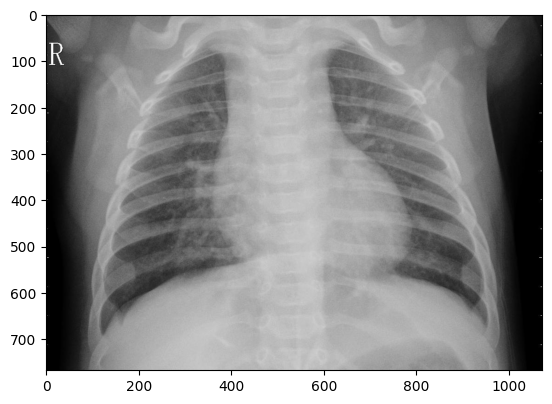


Sample normal lung image:


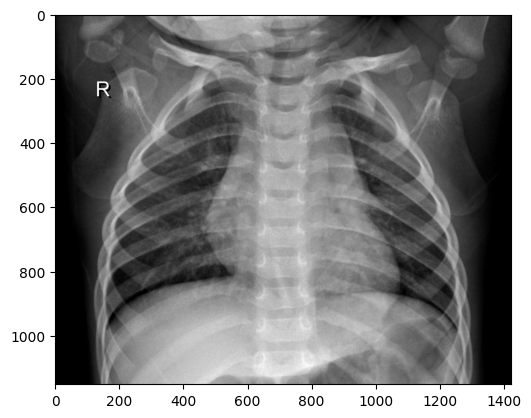

In [7]:
def check_sample(pneumonia_dir, normal_dir, index:int):
    print("Sample pneumonia lung image:")
    plt.imshow(load_img(f"{os.path.join(pneumonia_dir, os.listdir(pneumonia_dir)[index])}"))
    plt.show()

    print("\nSample normal lung image:")
    plt.imshow(load_img(f"{os.path.join(normal_dir, os.listdir(normal_dir)[index])}"))
    plt.show()

check_sample(train_pneumonia_dir, train_normal_dir, 1)

In [8]:
#Check Image Shape

def check_image_shape(index1:int, index2:int, index3:int):
    sample_image1  = load_img(f"{os.path.join(train_pneumonia_dir, os.listdir(train_pneumonia_dir)[index1])}")
    sample_image2  = load_img(f"{os.path.join(train_pneumonia_dir, os.listdir(train_pneumonia_dir)[index2])}")
    sample_image3  = load_img(f"{os.path.join(train_pneumonia_dir, os.listdir(train_pneumonia_dir)[index3])}")

    # Check image shape
    sample_array = [img_to_array(sample_image1), img_to_array(sample_image2), img_to_array(sample_image3)]

    for i in range(0,3):
        print(f"Each image {i} has shape: {sample_array[i].shape}")

check_image_shape(1,2,4)

Each image 0 has shape: (768, 1072, 3)
Each image 1 has shape: (863, 1244, 3)
Each image 2 has shape: (1280, 1488, 3)


this shows that images have different shape, we have to preprocess it first

### IMAGE AUGMENTATION

In [9]:
def create_image_generator(train_dir, val_dir):
    train_datagen = ImageDataGenerator(
        rescale = 1./255.,
        rotation_range = 40,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True
    )
    
    val_datagen = ImageDataGenerator(
        rescale = 1./255.
        )
    
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        batch_size = 20,
        class_mode = 'binary',
        target_size = (150,150)
    )

    val_generator = val_datagen.flow_from_directory(
        val_dir,
        batch_size = 20,
        class_mode = 'binary',
        target_size = (150,150)
    )

    return train_generator, val_generator
    

### CREATE MODEL

In [10]:
inceptionv3 = 'https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
urllib.request.urlretrieve(inceptionv3, 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')
local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model =  InceptionV3(input_shape=(150,150,3),include_top=False,weights=None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer =  pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

In [11]:
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(units=128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(units=64, activation='relu')(x)
x = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)

In [12]:
model = tf.keras.Model(pre_trained_model.input, x)

In [13]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['acc'])

In [14]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 72, 72,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 72, 72,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 35, 35,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 35, 35,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 33, 33,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 33, 33,    │          0 │ batch_normalizat

 Total params: 28,317,345 (108.02 MB)

 Trainable params: 19,342,081 (73.78 MB)

 Non-trainable params: 8,975,264 (34.24 MB)

In [15]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    # Check the loss
    if(logs.get('loss') < 0.015):
      # Stop if threshold is met
      print("\nLoss is lower than 0.015 so cancelling training!")
      self.model.stop_training = True

# Instantiate class
callbacks = myCallback()

In [16]:
history = model.fit(create_image_generator(train_dir,val_dir)[0],
                    epochs=50,
                    validation_data=create_image_generator(train_dir,val_dir)[1],
                    callbacks=[callbacks])

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/50


c:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


262/262 ━━━━━━━━━━━━━━━━━━━━ 146s 530ms/step - acc: 0.8519 - loss: 0.3291 - val_acc: 0.8654 - val_loss: 0.3740
Epoch 2/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 103s 390ms/step - acc: 0.9308 - loss: 0.1809 - val_acc: 0.8526 - val_loss: 0.4663
Epoch 3/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 103s 386ms/step - acc: 0.9381 - loss: 0.1502 - val_acc: 0.9071 - val_loss: 0.3004
Epoch 4/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 100s 378ms/step - acc: 0.9438 - loss: 0.1577 - val_acc: 0.8974 - val_loss: 0.4028
Epoch 5/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 102s 383ms/step - acc: 0.9503 - loss: 0.1292 - val_acc: 0.8974 - val_loss: 0.2700
Epoch 6/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 101s 379ms/step - acc: 0.9515 - loss: 0.1302 - val_acc: 0.8766 - val_loss: 0.4369
Epoch 7/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 97s 365ms/step - acc: 0.9502 - loss: 0.1271 - val_acc: 0.9151 - val_loss: 0.2671
Epoch 8/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 98s 371ms/step - acc: 0.9446 - loss: 0.1396 - val_acc: 0.9135 - val_loss: 0.2426
Epoch 9/50
262/262 ━━━━━━━━━━━━━━━━━━

### EVALUATION

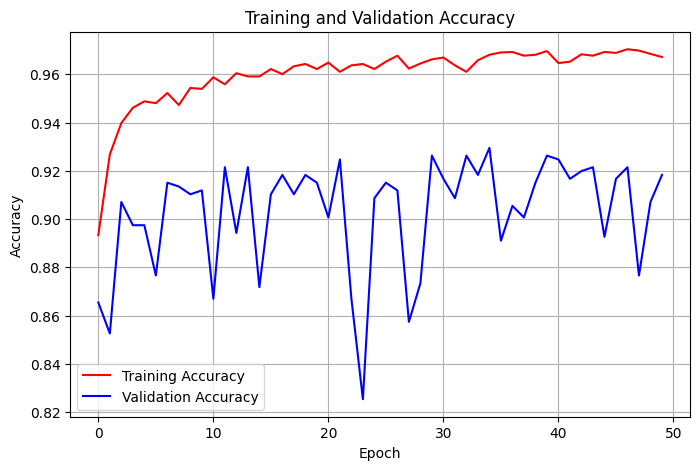

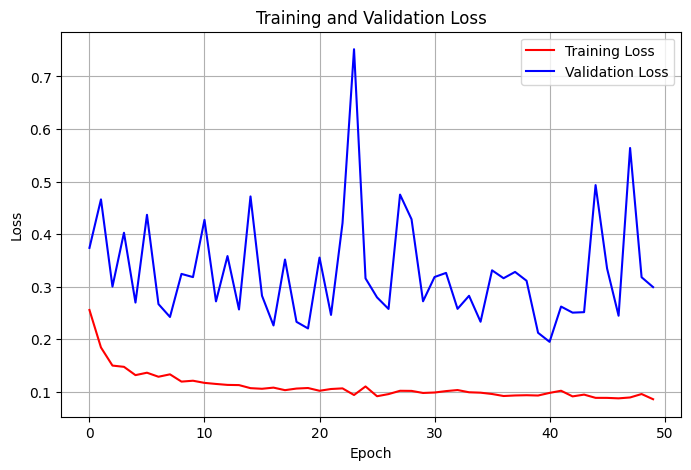

In [17]:
def check_evaluation():
    acc=history.history['acc']
    val_acc=history.history['val_acc']
    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs=range(len(acc)) # Get number of epochs

    # Plot training and validation accuracy per epoch
    plt.figure(figsize=(8, 5))  # Adjust figure size for better readability
    plt.plot(epochs, acc, 'r', label="Training Accuracy")
    plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()  # Add the legend here
    plt.grid(True)  # Add grid lines for better visualization
    plt.show()
    print("")

    # Plot training and validation loss per epoch
    plt.figure(figsize=(8, 5))  # Adjust figure size for better readability
    plt.plot(epochs, loss, 'r', label="Training Loss")
    plt.plot(epochs, val_loss, 'b', label="Validation Loss")
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()  # Add the legend here
    plt.grid(True)  # Add grid lines for better visualization
    plt.show()

check_evaluation()

### SAVE MODEL

In [18]:
model.save('model_capstone.h5')